(mmm_time_slice_cross_validation)=
# Time-Slice-Cross-Validation and Parameter Stability

In this notebook we will illustrate how to perform time-slice cross validation for a media mix model. This is an important step to evaluate the stability and quality of the model. We not only look into out of sample predictions but also the stability of the model parameters.

These imports and configurations form the fundamental setup necessary for the entire span of this notebook.

The expectation is that a model has already been trained using the functionalities provided in prior versions of the PyMC-Marketing library. Thus, the data generation and training processes will be replicated in a different notebook. Those unfamiliar with these procedures are advised to refer to the ["MMM Example Notebook."](https://www.pymc-marketing.io/en/stable/notebooks/mmm/mmm_example.html)

## Prepare Notebook

In [25]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pymc_marketing.mmm.time_slice_cross_validation import TimeSliceCrossValidator
from pymc_marketing.paths import data_dir

warnings.simplefilter(action="ignore", category=FutureWarning)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"


%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

## Loading Data
Here we will load our geo level dataset. This will then be used within our Time-Slice CV steps.

In [3]:
data_path = data_dir / "multidimensional_mock_data.csv"
data_df = pd.read_csv(data_path, parse_dates=["date"], index_col=0)
data_df.head()

date            y          x1   x2  event_1  event_2  dayofyear  t  \
0 2018-04-02  3984.662237  159.290009  0.0      0.0      0.0         92  0   
1 2018-04-09  3762.871794   56.194238  0.0      0.0      0.0         99  1   
2 2018-04-16  4466.967388  146.200133  0.0      0.0      0.0        106  2   
3 2018-04-23  3864.219373   35.699276  0.0      0.0      0.0        113  3   
4 2018-04-30  4441.625278  193.372577  0.0      0.0      0.0        120  4   

     geo  
0  geo_a  
1  geo_a  
2  geo_a  
3  geo_a  
4  geo_a

In [4]:
X = data_df.drop(columns=["y"])
y = data_df["y"]

## Specify Time-Slice-Cross-Validation Strategy

The main idea of the time-slice cross validation process is to fit the model on a time slice of the data and then evaluate it on the next time slice. We repeat this process for each time slice of the data. As we want to simulate a production-like environment where we enlarge our training data over time, we make the time-slice size grow over time.

```{admonition} Data Leakage
:class: warning

It is very important to avoid data leakage when performing time-slice cross validation. This means that the model should not see any training data from the future. This also includes any data pre-processing steps!

For example, as mentioned above, we need to compute the costs share for each training time slice independently if we want to avoid data leakage. Other sources of data leakage include using a global feature for thr trend component. In our case, we simply use an increasing variable `t` so we are safe as we just increase it by one for each time slice.
```

## Run Time-Slice-Cross-Validation Loop

Depending on the business requirements, we need to decide the initial number of observations to use for fitting the model (`n_init`) and the forecast horizon (`forecast_horizon`). For this example, we use the first 342 observations to fit the model and then predict the next 12 observations (3 months).

In [27]:
# Initialize cross-validator
cv = TimeSliceCrossValidator(
    n_init=163,
    forecast_horizon=12,
    date_column="date",
    step_size=1,
)

In [28]:
# We can check how many splits we will have
# As a reference, the number of splits is computed as:
# n_iterations = y.size - n_init - forecast_horizon + 1
n_splits = cv.get_n_splits(X, y)
print(f"Number of splits: {n_splits}")

Number of splits: 5


Let's run it! 

For more details on the `build_mmm_from_yaml`, consult the [pymc-marketing documentation](https://www.pymc-marketing.io/en/stable/guide/benefits) on Model Deployment.

Alternatively, load a model that has been saved to MLflow via `pymc_marketing.mlflow.log_inference_data` or has been autologged to MLflow via `pymc_marketing.mlflow.autolog(log_mmm=True)`, from the [PyMC-Marketing MLflow module](https://github.com/pymc-labs/pymc-marketing/blob/main/pymc_marketing/mlflow.py).

In [29]:
results = cv.run(
    X,
    y,
    # You can also pass sampler_config here to speed things up
    sampler_config={
        "tune": 500,
        "draws": 200,
        "chains": 4,
        "random_seed": 123,
        "target_accept": 0.90,
    },
    yaml_path=data_dir / "config_files" / "multi_dimensional_example_model.yml",
)

0it [00:00, ?it/s]

/Users/tim/code/pymc-marketing/pymc_marketing/mmm/builders/yaml.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[date_column] = pd.to_datetime(X[date_column])
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_contribution, adstock_alpha, saturation_lam, saturation_beta, gamma_control, gamma_fourier_b, gamma_fourier, delta_b, delta, y_sigma_sigma, y_sigma]


Output()

Sampling 4 chains for 500 tune and 200 draw iterations (2_000 + 800 draws total) took 11 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Sampling: [y]
/Users/tim/code/pymc-marketing/pymc_marketing/mmm/builders/yaml.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[date_column] = pd.to_datetime(X[date_column])
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_contribution, adstock_alpha, saturation_lam, saturation_beta, gamma_control, gamma_fourier_b, gamma_fourier, delta_b, delta, y_sigma_sigma, y_sigma]


Output()

Sampling 4 chains for 500 tune and 200 draw iterations (2_000 + 800 draws total) took 11 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Sampling: [y]
/Users/tim/code/pymc-marketing/pymc_marketing/mmm/builders/yaml.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[date_column] = pd.to_datetime(X[date_column])
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_contribution, adstock_alpha, saturation_lam, saturation_beta, gamma_control, gamma_fourier_b, gamma_fourier, delta_b, delta, y_sigma_sigma, y_sigma]


Output()

Sampling 4 chains for 500 tune and 200 draw iterations (2_000 + 800 draws total) took 10 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Sampling: [y]
/Users/tim/code/pymc-marketing/pymc_marketing/mmm/builders/yaml.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[date_column] = pd.to_datetime(X[date_column])
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_contribution, adstock_alpha, saturation_lam, saturation_beta, gamma_control, gamma_fourier_b, gamma_fourier, delta_b, delta, y_sigma_sigma, y_sigma]


Output()

Sampling 4 chains for 500 tune and 200 draw iterations (2_000 + 800 draws total) took 10 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Sampling: [y]
/Users/tim/code/pymc-marketing/pymc_marketing/mmm/builders/yaml.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[date_column] = pd.to_datetime(X[date_column])
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_contribution, adstock_alpha, saturation_lam, saturation_beta, gamma_control, gamma_fourier_b, gamma_fourier, delta_b, delta, y_sigma_sigma, y_sigma]


Output()

Sampling 4 chains for 500 tune and 200 draw iterations (2_000 + 800 draws total) took 10 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Sampling: [y]


In [30]:
# We can view the cross-validation results!
# The CV object is an instance of ArviZ InferenceData
results

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data
	> fit_data
	> posterior_predictive_constant_data
	> cv_metadata

## Model Diagnostics

First, we evaluate whether we have any divergences in the model (we can extend the analysis more more model diagnostics).

In [31]:
# Let's check if there are any divergences
diverging_count = int(results.sample_stats["diverging"].values.sum())
print("Diverging transitions:", diverging_count)

Diverging transitions: 0


We have no divergences in the model 😃!

## Evaluate Parameter Stability

Next, we look at the stability of the model parameters. For a good model, these should not change abruptly over time.

- Adstock Alpha

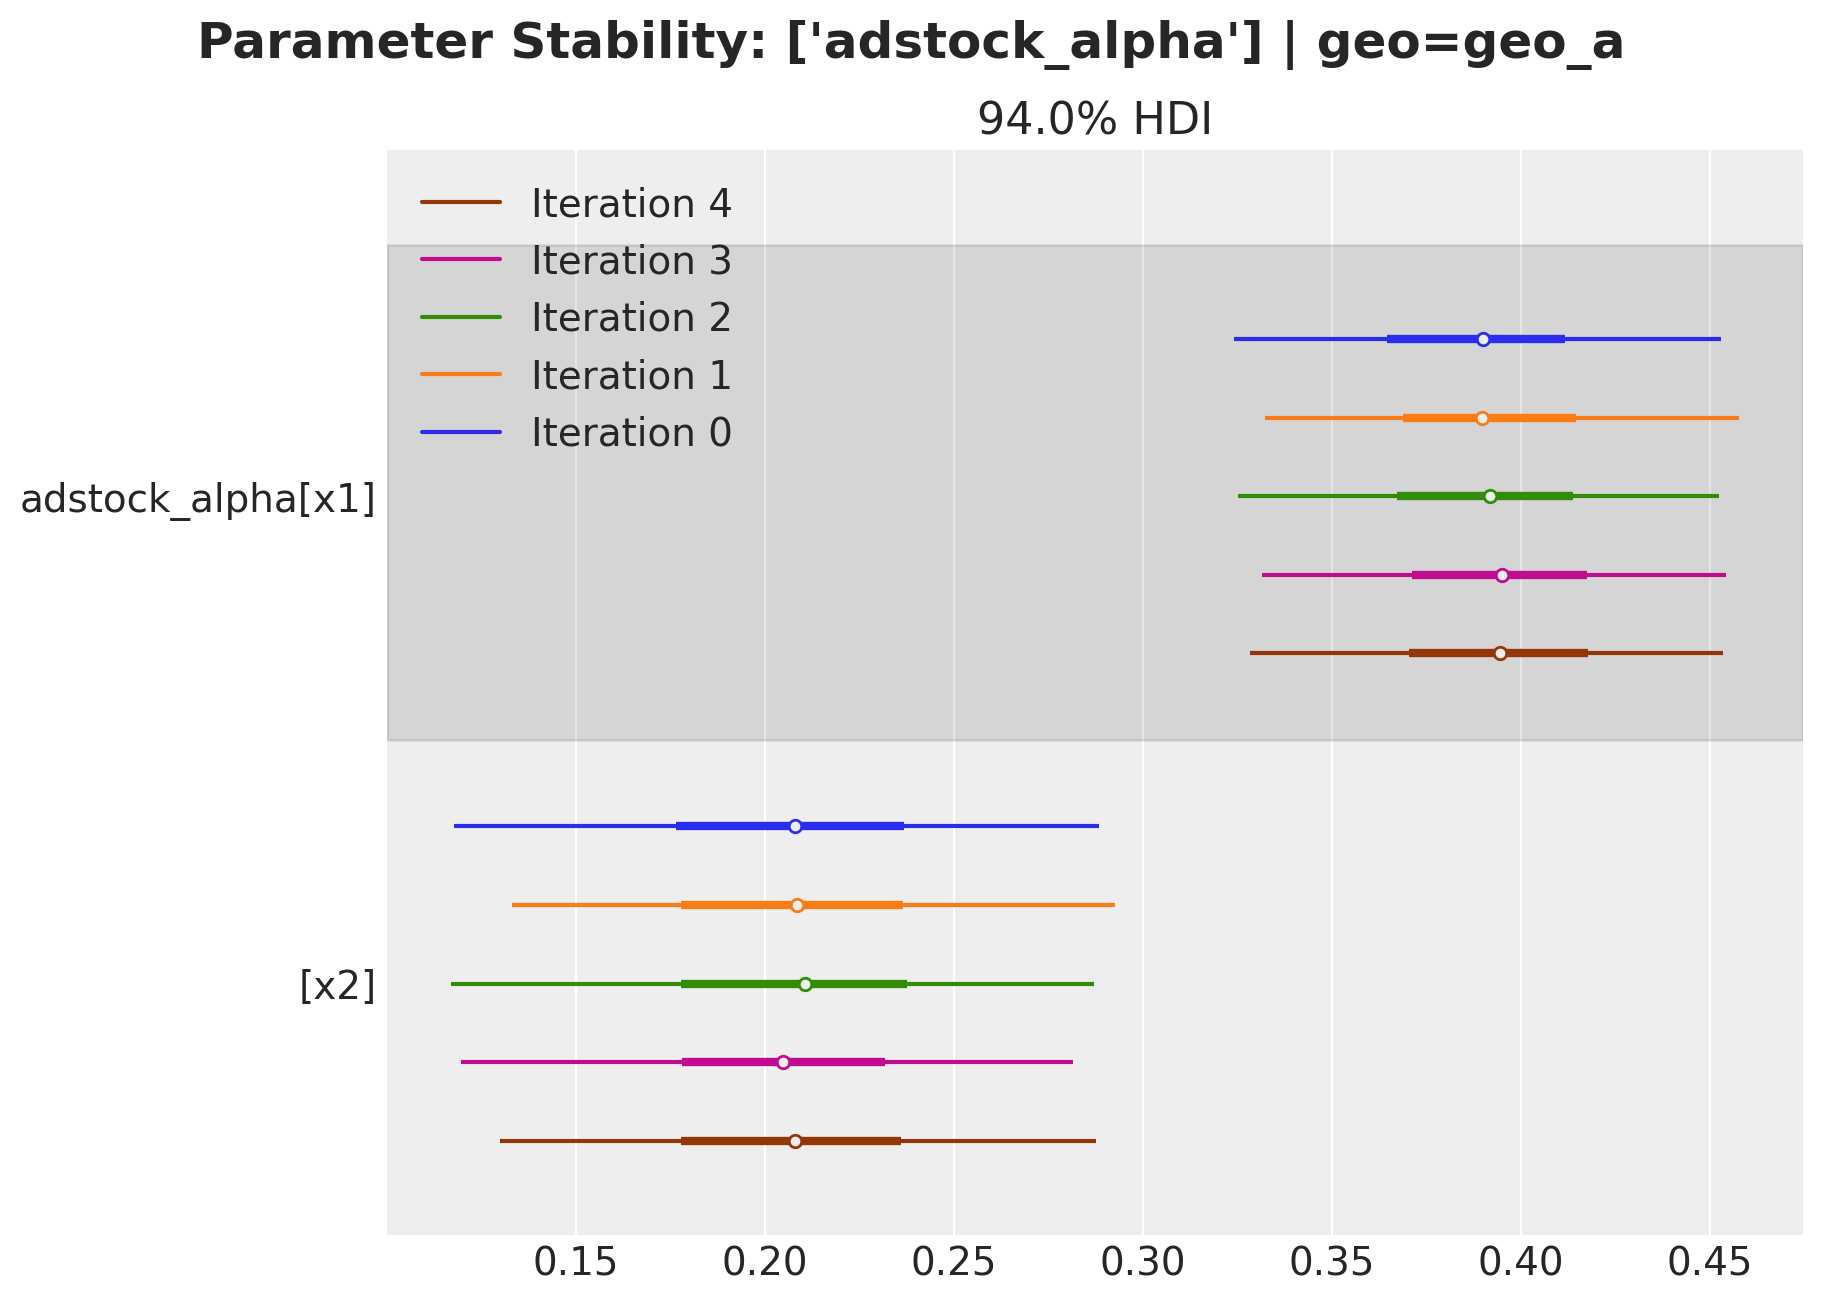

In [32]:
cv.plot.param_stability(
    results=results,
    parameter=["adstock_alpha"],
    dims={"geo": ["geo_a"]},
);

- Saturation Beta

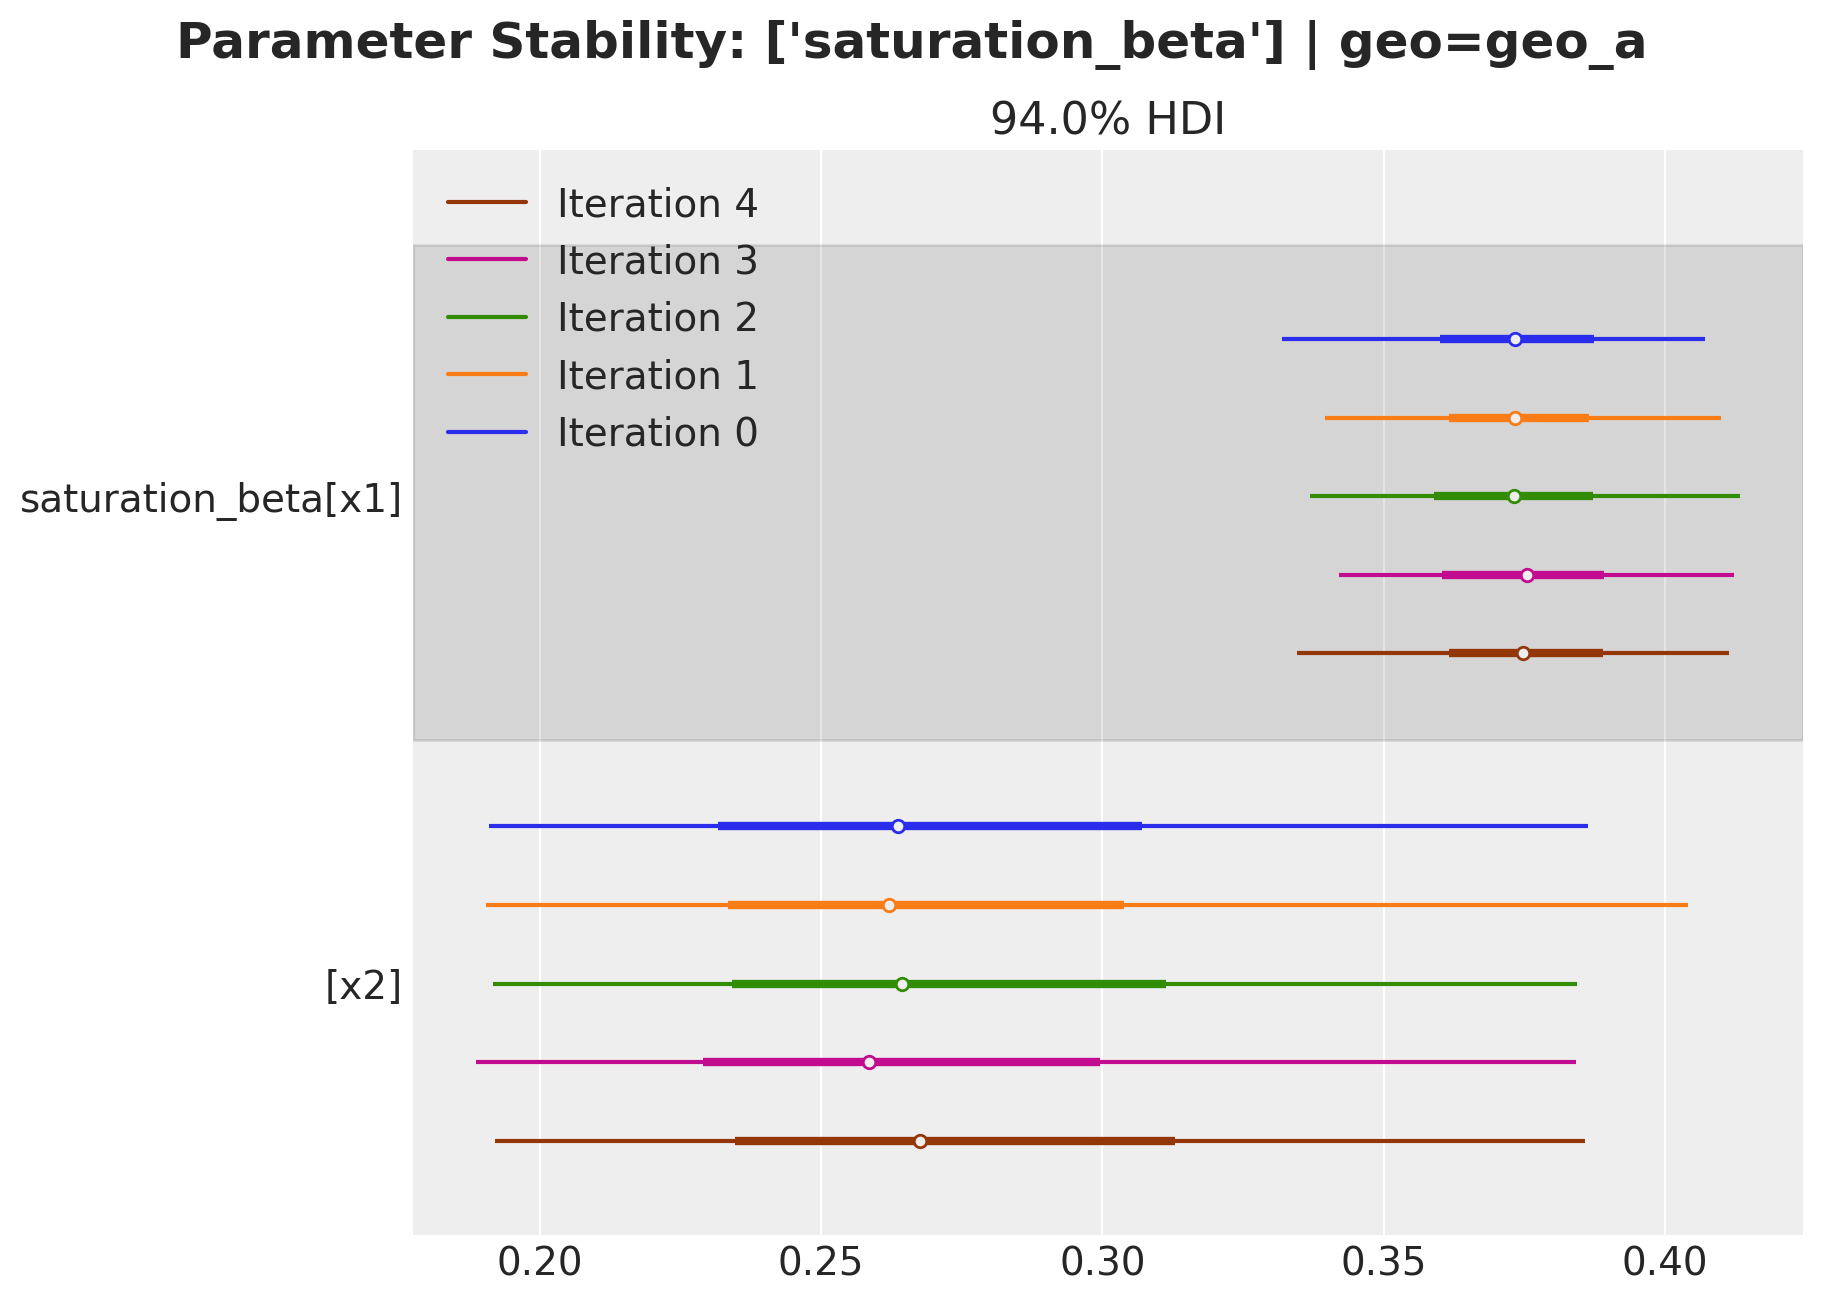

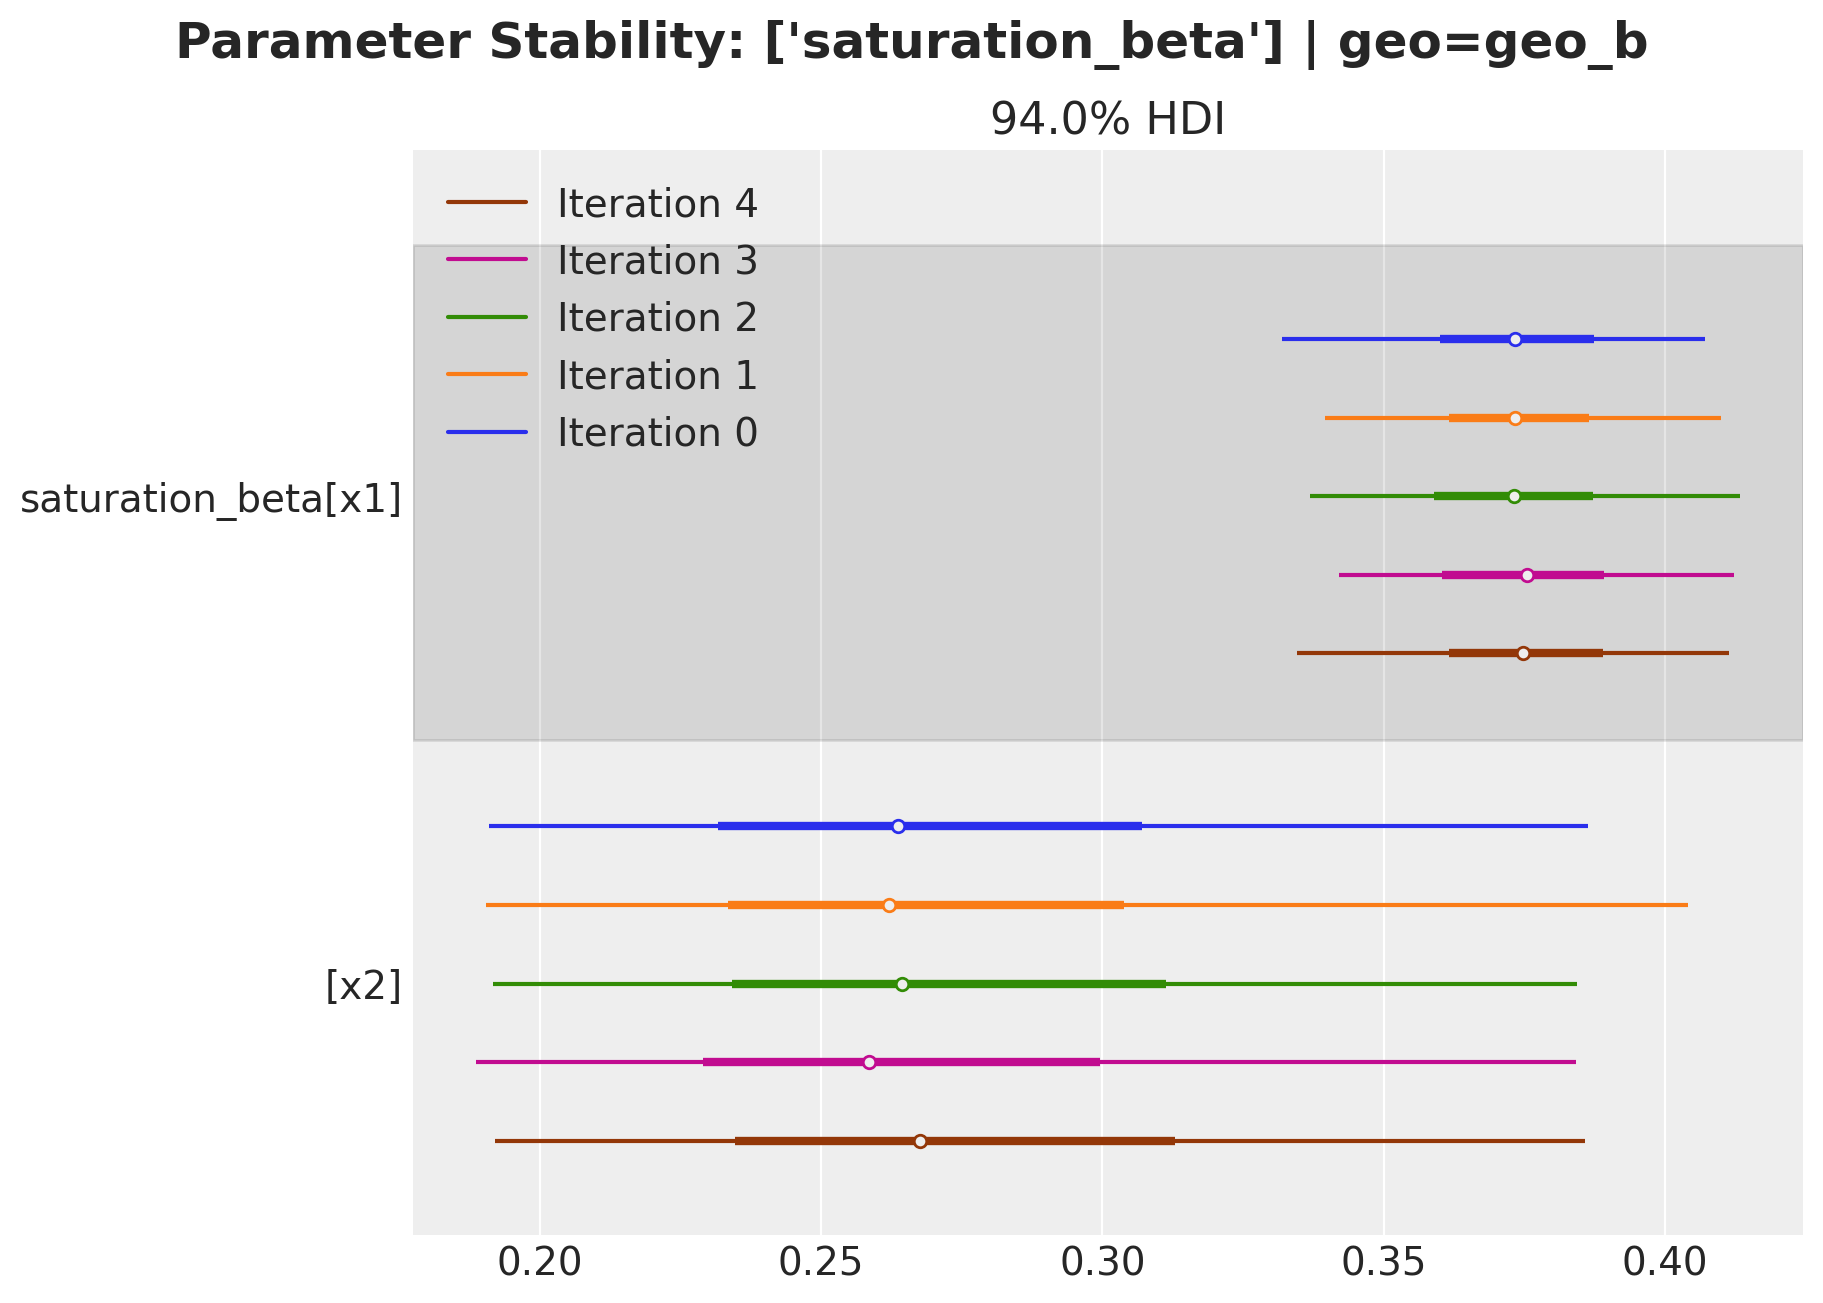

In [33]:
cv.plot.param_stability(
    results,
    parameter=["saturation_beta"],
    dims={"geo": ["geo_a", "geo_b"]},
);

- Saturation Lambda

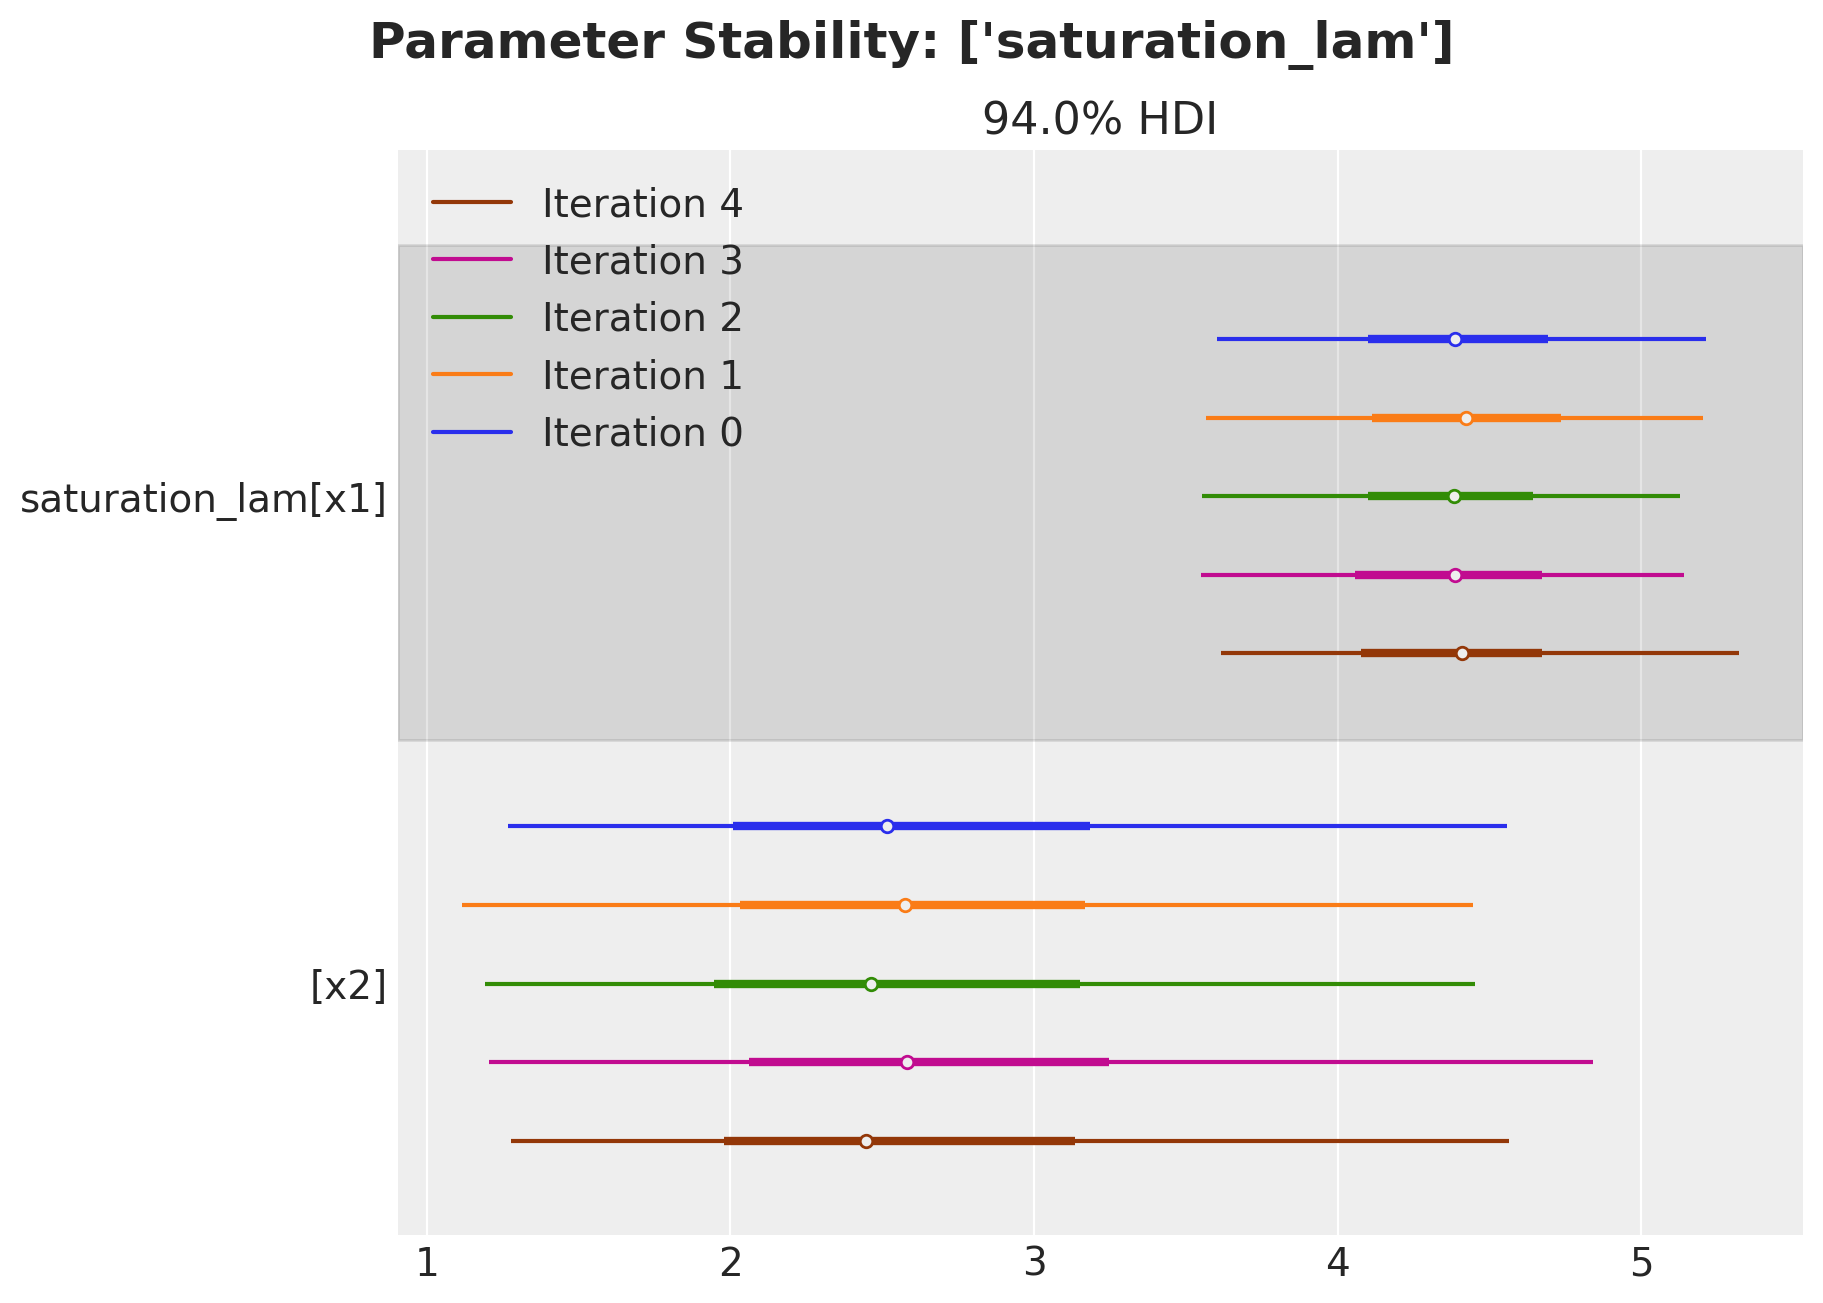

In [34]:
cv.plot.param_stability(
    results,
    parameter=["saturation_lam"],
    # dims={"geo": ["geo_a", "geo_b"]}
);

The parameters seem to be stable over time. This implies that the estimates ROAS will not change abruptly over time.

## Evaluate Out of Sample Predictions

Finally, we evaluate the out of sample predictions. To begin with, we can simply plot the posterior predictive distributions for each iteration for both the training and test data.

/Users/tim/code/pymc-marketing/pymc_marketing/mmm/plot.py:3233: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.07, 1, 1])


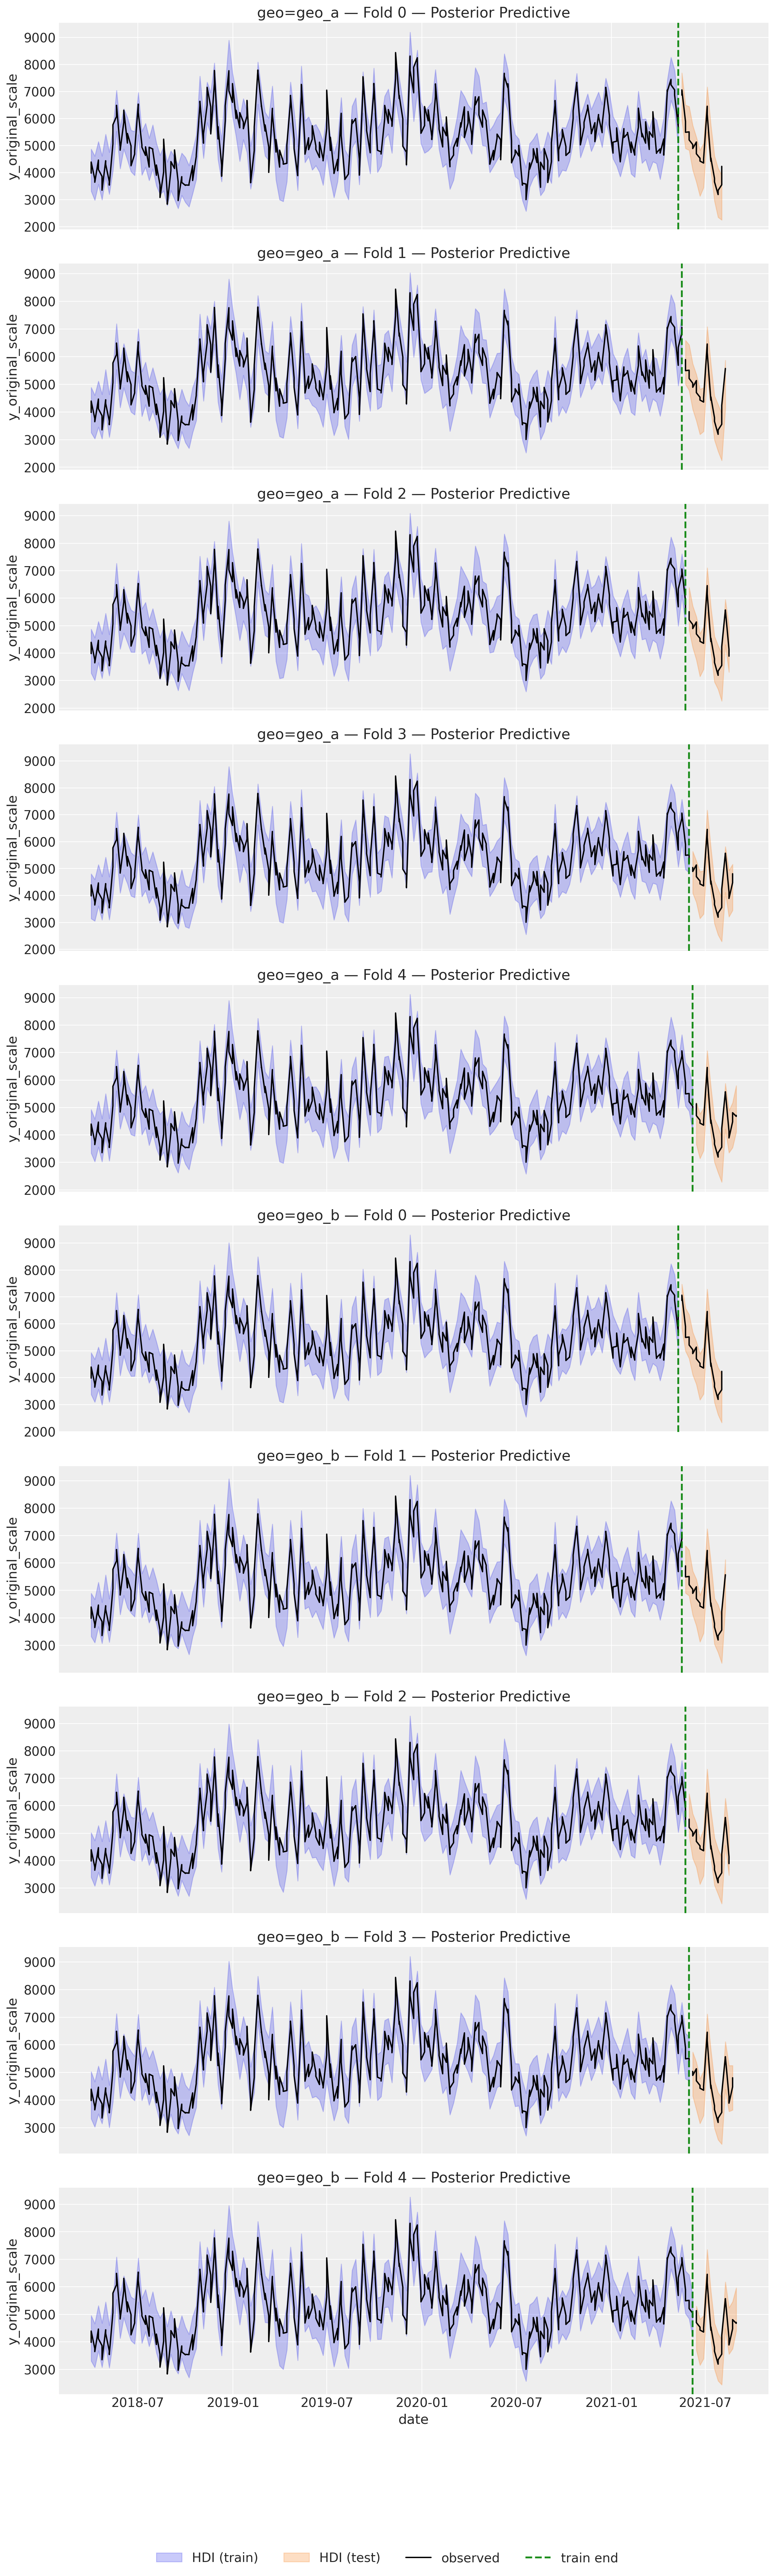

In [35]:
# Plot model predictions across time slices
cv.plot.cv_predictions(
    results,
    # dims={"geo": ["geo_b"]} # to plot specific dimensions only
);

Overall, the out of sample predictions look very good 🚀!

We can quantify the model performance using the Continuous Ranked Probability Score (CRPS).

> *“The CRPS — Continuous Ranked Probability Score — is a score function that compares a single ground truth value to a Cumulative Distribution Function. It can be used as a metric to evaluate a model’s performance when the target variable is continuous and the model predicts the target’s distribution; Examples include Bayesian Regression or Bayesian Time Series models.”*


For a nice explanation of the CRPS, check out this [blog post](https://towardsdatascience.com/crps-a-scoring-function-for-bayesian-machine-learning-models-dd55a7a337a8).

In PyMC-Marketing, we provide the function {func}`crps <pymc_marketing.metrics.crps>` to compute this metric. We can use it to compute the CRPS score for each iteration.

/Users/tim/code/pymc-marketing/pymc_marketing/mmm/plot.py:3700: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


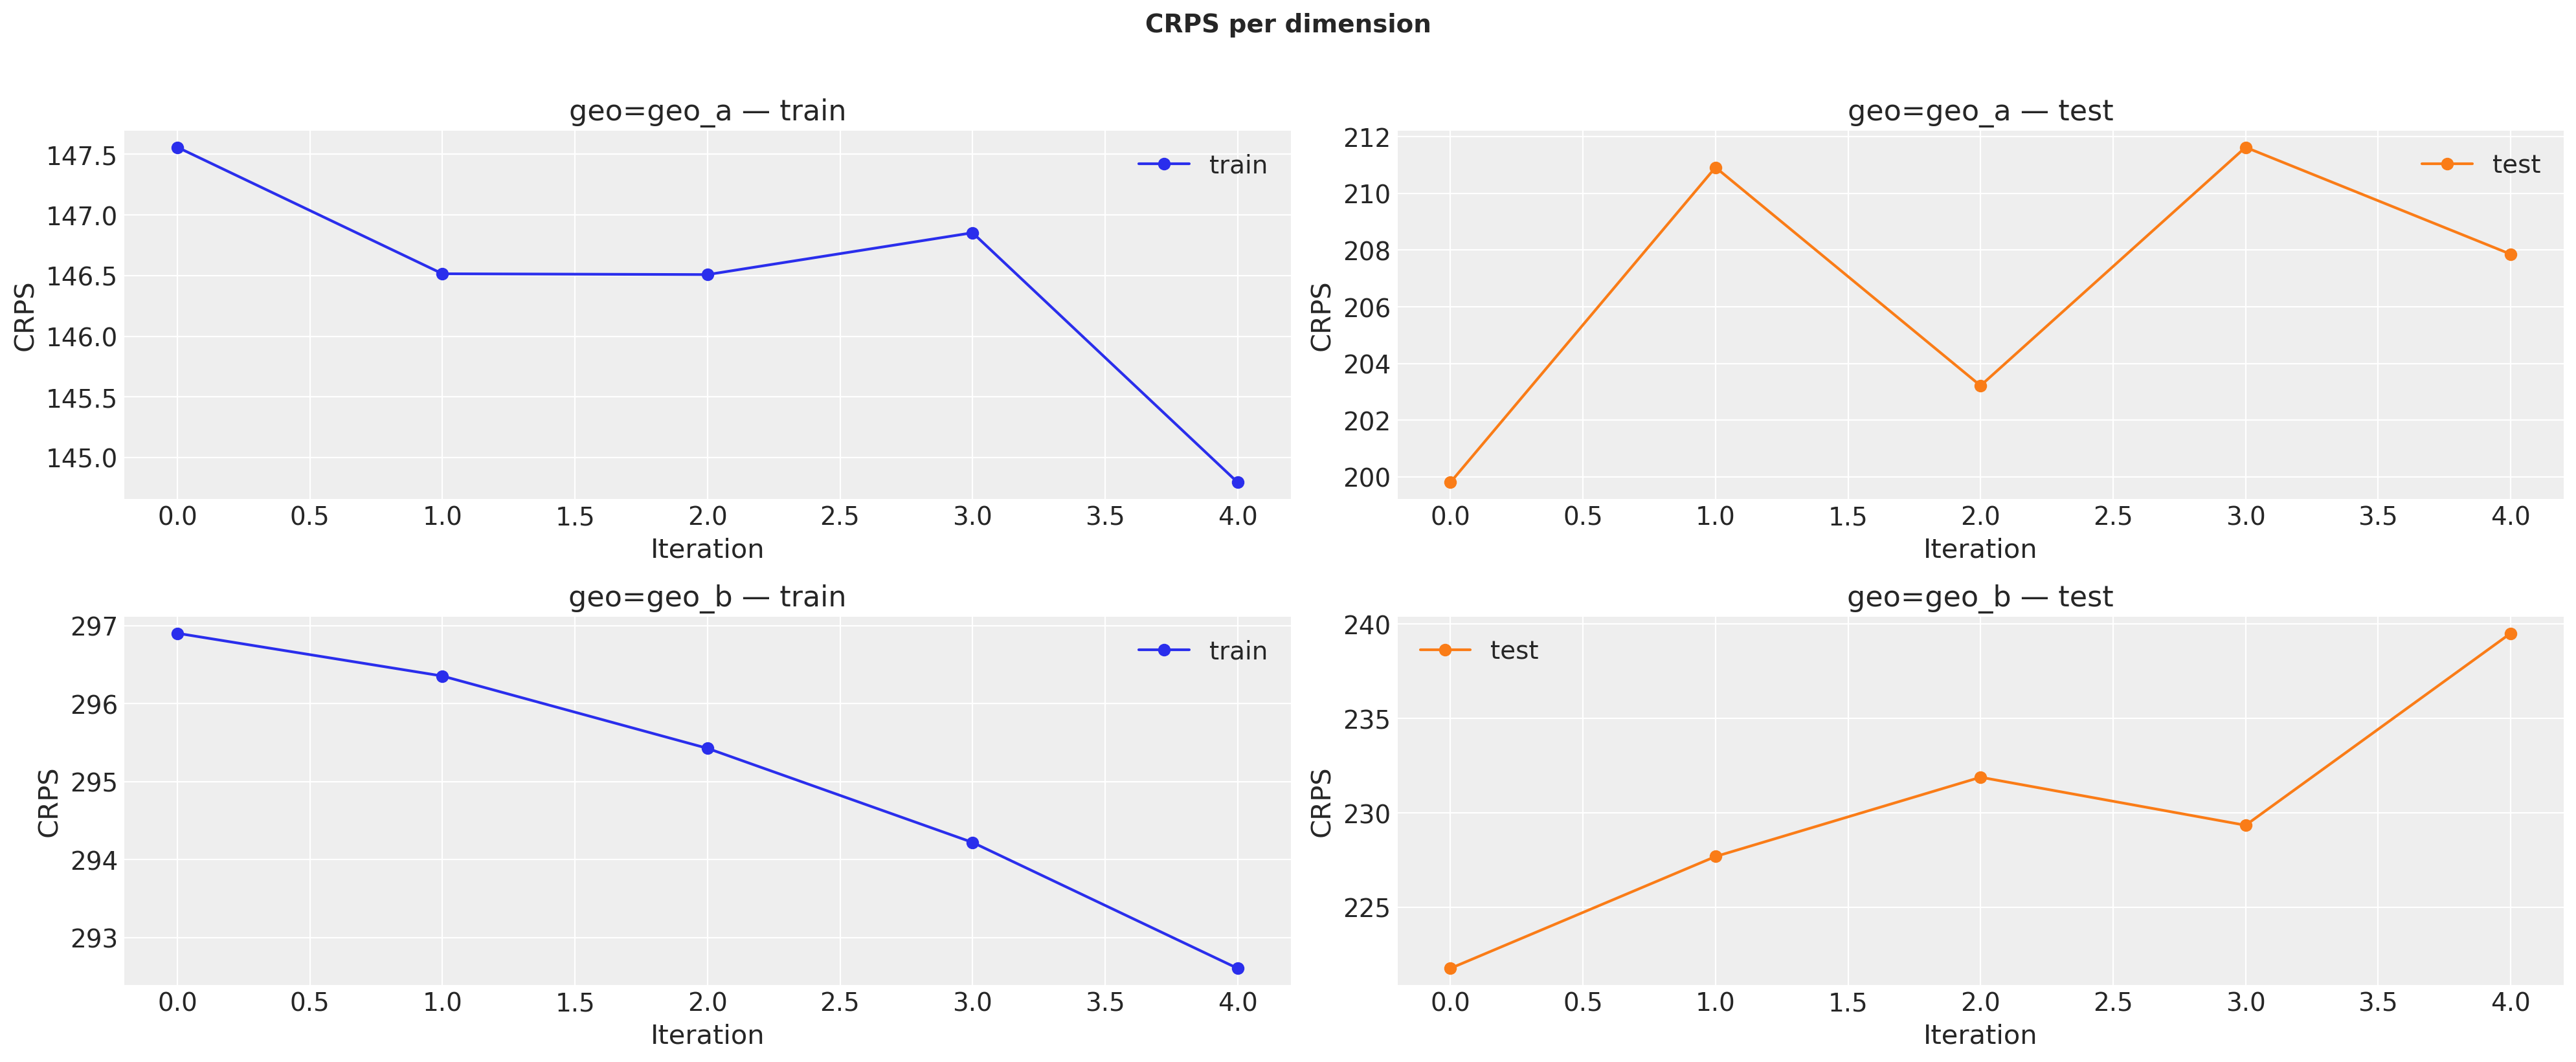

In [36]:
# Compute the CRPS score for each iteration and plot!
cv.plot.cv_crps(
    results,
    # dims={"geo": ["geo_b"]} # to plot specific dimensions only
);

Event though the visual results look great, we see that the CRPS mildly decreases for the training data while it increases for the test data as we increase the size of the training data. This is a sign that we are overfitting the model to the training data. Some strategies to overcome this issue include using regularization techniques and re-evaluate the model specification. This should be an iterative process.

In [16]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pymc_marketing,pytensor,numpyro

Last updated: Sun Aug 25 2024

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

pymc_marketing: 0.8.0
pytensor      : 2.22.1
numpyro       : 0.15.2

matplotlib: 3.9.0
pandas    : 2.2.2
arviz     : 0.19.0
numpy     : 1.26.4

Watermark: 2.4.3

